Proteome Database at ftp://ftp.pride.ebi.ac.uk/pride/data/archive/2019/02/PXD010154/ <br>
Paper at https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6379049/pdf/MSB-15-e8503.pdf <br>
RNA fastqs database ftp://ftp.sra.ebi.ac.uk/vol1/fastq/ERR315/ <br>
rna expression https://www.ebi.ac.uk/arrayexpress/experiments/E-MTAB-2836/ <br>

In [1]:
import pandas as pd
from gtfparse import read_gtf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import time
from collections import Counter

### RNA seq processing

In [ ]:
rna = pd.read_csv('../RNA-seq/E-MTAB-2836-query-results_trans.tpms.tsv',sep='\t',skiprows =4,index_col=0)
rna = rna.drop(columns=['Gene Name','bone marrow', 'skeletal muscle tissue','zone of skin'])
rna = rna.fillna(0) #converts nan to 0

rna.head()
#length 45946

In [2]:
#Reading new fpkm excel file

rna_fpkm = pd.read_excel('../RNA-seq/Table_EV2.xlsx',sheet_name='B. Genes',index_col=0)
rna_fpkm_subset = rna_fpkm.drop(labels=['Gene name','Tissue enriched','Group enriched','Tissue enhance','Classification'],axis=1)
rna_fpkm.head()

,Gene name,Adrenal gland,Appendix,Brain,Colon,Duodenum,Endometrium,Esophagus,Fallopian tube,Fat,...,Spleen,Stomach,Testis,Thyroid,Tonsil,Urinary bladder,Tissue enriched,Group enriched,Tissue enhance,Classification
Gene ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,TSPAN6,16.26,4.82,15.67,50.18,18.84,22.48,29.71,66.47,16.70,...,7.69,16.45,51.02,13.63,8.38,14.84,Fallopian tube,NaN,NaN,Expressed in all
ENSG00000000005,TNMD,0.00,0.00,0.00,1.06,0.00,0.00,0.00,0.00,4.39,...,0.00,0.00,0.00,0.00,0.00,0.00,Placenta,Colon;Fat;Placenta,NaN,Group enriched
ENSG00000000419,DPM1,42.32,34.59,14.85,32.06,26.30,36.88,35.89,31.67,31.11,...,25.96,24.92,37.45,47.41,43.15,32.92,Thyroid,NaN,NaN,Expressed in all
ENSG00000000457,SCYL3,4.48,5.95,3.14,7.47,5.04,5.05,4.59,5.81,1.65,...,5.34,6.58,5.48,4.48,7.70,5.48,Lymph node,NaN,NaN,Mixed
ENSG00000000460,C1orf112,1.06,2.25,0.00,2.82,0.00,2.31,0.00,0.00,0.00,...,0.00,0.00,3.86,0.00,4.00,0.93,Tonsil,NaN,Testis;Tonsil,Tissue enhanced


### GTF Reference file processing


In [3]:
start = time.time()
#df = read_gtf('../Genomes/Homo_sapiens.GRCh38.79.gtf')
df = read_gtf('../Genomes/Homo_sapiens.GRCh38.83.gtf')
print(time.time()-start)

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'havana_gene', 'havana_gene_version', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'havana_transcript', 'havana_transcript_version', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'ccds_id', 'protein_id', 'protein_version']


156.12447571754456


In [4]:
#Gets unique gene to protein mappings, can have duplicated genes since isoforms
mappings = df[['gene_id','transcript_id','protein_id','protein_version']] 
matched_unique_proteins = mappings[mappings['protein_id']!=''].drop_duplicates(subset='protein_id') #empty columns values are empty string ''
#length 100778
#if you remove duplicated genes, then 22489 unique genes

In [5]:
#Gets all unique genes, with or without matching proteins
all_genes = mappings.drop_duplicates(subset='gene_id') 
#length 65217

#### Unique genes in both rna and all genes, checks that all genes in rna-seq are actually in reference

In [ ]:
len(set(rna.index)&set(all_genes['gene_id'])) 

In [6]:
len(set(rna_fpkm.index)&set(all_genes['gene_id'])) 

18072

#### Genes in both rna and matched unique proteins, paper has 18,072 using a cutoff of 1 fpkm

In [ ]:
len(set(rna.index)&set(matched_unique_proteins['gene_id'])) 

In [7]:
len(set(rna_fpkm.index)&set(matched_unique_proteins['gene_id'])) 

18072

In [10]:
#Thresholding for FPKM
thresh=1
rna_thresh = rna_fpkm_subset[(rna_fpkm_subset<=thresh).sum(axis=1)!=29] #removes genes that have expression level for ALL TISSUES less than or equal to thresh
missing_thresh_genes = set(rna_thresh.index)-set(matched_unique_proteins['gene_id'])
matched_thresh_genes = set(rna_thresh.index)&set(matched_unique_proteins['gene_id'])
rna_missing = rna_thresh.loc[list(missing_thresh_genes)]
rna_thresh = rna_thresh.loc[list(matched_thresh_genes)]
len(matched_thresh_genes)

18004

In [ ]:
#value depending on TPM threshold, since nan is replace with 0 setting really small threshold
#is required to remove nan values (nan values only is 19498 overlapping)
thresh = 2
rna_thresh = rna[(rna<=thresh).sum(axis=1)!=29] #removes genes that have expression level for ALL TISSUES less than or equal to thresh
missing_thresh_genes = set(rna_thresh.index)-set(matched_unique_proteins['gene_id'])
matched_thresh_genes = set(rna_thresh.index)&set(matched_unique_proteins['gene_id'])
rna_missing = rna_thresh.loc[list(missing_thresh_genes)]
rna_thresh = rna_thresh.loc[list(matched_thresh_genes)]
len(matched_thresh_genes)

#### Numer of unique genes per tissue above threshold (keep threshold same as above)

In [11]:
#Comment out line below if using original matrix
#rna_thresh = rna_fpkm_subset.copy()

start=time.time()
col_names=['all','t_enhanced','t_enriched','mixed','g_enriched']
rna_thresh_classified = pd.DataFrame(index=rna_thresh.index,columns=col_names)
for gene in rna_thresh_classified.index:
    #Gene can only fall into 1 of the 5 categories, but can have multiple tisues for it
    # 1 Expressed in all -> tpm above thresh for all tissuse
    # 2 tissue-enriched, a single tissue, 5 fold higher than the rest of tissues
    # 3 group-enriched, 5-fold higher average TPM value in a group of 2-7 tissues compared to all other tissues
    # 4 tissue-enhanced - 5-fold higher in a tissue compared to avg of all other tissues
    # 5 mixed - genes with tpm>thresh and not fitting into any of the categories above
    
    #rank the expression level of each tissue, used in conditions below
    ranked = rna_thresh.loc[gene].sort_values(ascending=False)
    
    #avg of top groups,7,6,...2, descending order
    group_means = [ranked[0:7-i].mean() for i in range(7)]
    
    #average over all values
    avg = np.mean(ranked)
    
    if all(rna_thresh.loc[gene]>thresh):
        rna_thresh_classified.at[gene,'all']=1
        
    elif all(ranked[0]>=5*ranked[1::]):
        rna_thresh_classified.at[gene,'t_enriched']=ranked.index[0]
        
    elif any([all(avg>=5*ranked[7-i::]) for i,avg in enumerate(group_means)]):
        for i in range(7):
            if all(group_means[i]>=5*ranked[7-i::]):
                rna_thresh_classified.at[gene,'g_enriched']=','.join(ranked.index[0:7-i])
                break
                
    elif any([val>5*avg for val in ranked]):
        genes=[]
        for i, val in enumerate(ranked):
            if val>=5*avg:
                genes.append(ranked.index[i])
        rna_thresh_classified.at[gene,'t_enhanced']=','.join(genes)
    
    else:
        genes=[]
        for i, val in enumerate(ranked):
            if val>thresh:
                genes.append(ranked.index[i])
        rna_thresh_classified.at[gene,'mixed']=','.join(genes)

print(f'runtime {time.time()-start}')

runtime 95.77426171302795


##### Expressed in all

In [12]:
exp_all = sum(~rna_thresh_classified['all'].isnull())
exp_all

6765

In [15]:
#tissue enriched
tis_enriched=','.join(rna_thresh_classified['t_enriched'][~rna_thresh_classified['t_enriched'].isnull()])
tis_enriched = tis_enriched.split(',')
tis_enriched_counted = Counter(tis_enriched)
#tis_enriched_counted

In [16]:
#group enriched
grp_enriched=','.join(rna_thresh_classified['g_enriched'][~rna_thresh_classified['g_enriched'].isnull()])
grp_enriched = grp_enriched.split(',')
grp_enriched_counted = Counter(grp_enriched)
#grp_enriched_counted

In [17]:
#tissue enhanced
tis_enhanced = ','.join(rna_thresh_classified['t_enhanced'][~rna_thresh_classified['t_enhanced'].isnull()])
tis_enhanced = tis_enhanced.split(',')
tis_enhanced_counted = Counter(tis_enhanced)
#tis_enhanced_counted

In [18]:
#Mixed
mixed = ','.join(rna_thresh_classified['mixed'][~rna_thresh_classified['mixed'].isnull()])
mixed = mixed.split(',')
mixed_counted = Counter(mixed)
#mixed_counted

In [19]:
#Number of significantly detected genes per tissue
tissue_genes_thresh = {}
for tis in rna_thresh.columns:
    tissue_genes_thresh[tis] = sum(rna_thresh[tis]>thresh)
#tissue_genes_thresh

In [20]:
#Categorized groupings
total = tis_enriched_counted + grp_enriched_counted + tis_enhanced_counted + mixed_counted
for index in total.keys():
    total[index] += exp_all
#total

In [21]:
exp_all_dict={}
for tissue in list(rna_thresh.columns):
    exp_all_dict[tissue] = exp_all
    if tissue not in tis_enriched_counted.keys():
        tis_enriched_counted[tissue]=0
    if tissue not in grp_enriched_counted.keys():
        grp_enriched_counted[tissue]=0
    if tissue not in tis_enhanced_counted.keys():
        tis_enhanced_counted[tissue]=0
    if tissue not in mixed_counted.keys():
        mixed_counted[tissue]=0
exp_all_dict = Counter(exp_all_dict)

classified = pd.DataFrame([exp_all_dict,mixed_counted,tis_enhanced_counted,grp_enriched_counted,tis_enriched_counted]).T
classified.columns=['all','mixed','tis_enhanced','grp_enriched','tis_enriched']
running_sum=classified.cumsum(axis=1)
classified.head()

,all,mixed,tis_enhanced,grp_enriched,tis_enriched
Adrenal gland,6765,3155,85,515,57
Appendix,6765,3194,94,1798,15
Brain,6765,2933,279,1609,320
Colon,6765,3087,58,1277,6
Duodenum,6765,3110,84,863,13


In [ ]:
#TPM FIGURE
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches((10,10))

ax.barh(classified.index,classified['all'],color='paleturquoise')
ax.barh(classified.index,classified['mixed'],left=running_sum['all'],color='mediumturquoise')
ax.barh(classified.index,classified['tis_enhanced'],left=running_sum['mixed'],color='deepskyblue')
ax.barh(classified.index,classified['grp_enriched'],left=running_sum['tis_enhanced'],color='steelblue')
ax.barh(classified.index,classified['tis_enriched'],left=running_sum['grp_enriched'],color='navy')
ax.invert_yaxis()
ax.set_title("TPM Thresholded Classified Transcripts Per Tissue (122 sample database)")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(['All','Mixed','Tissue Enhanced','Group Enhanced','Tissue Enriched'],loc='center left', bbox_to_anchor=(1, 0.5))
#fig.savefig('TPM_thresholded.png',bbox_inches='tight')

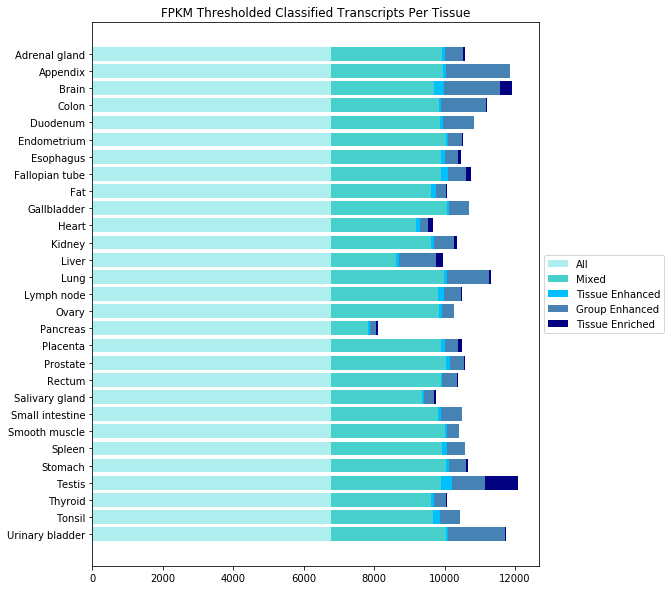

In [23]:
#FPKM DATABASE
fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches((10,10))

ax.barh(classified.index,classified['all'],color='paleturquoise')
ax.barh(classified.index,classified['mixed'],left=running_sum['all'],color='mediumturquoise')
ax.barh(classified.index,classified['tis_enhanced'],left=running_sum['mixed'],color='deepskyblue')
ax.barh(classified.index,classified['grp_enriched'],left=running_sum['tis_enhanced'],color='steelblue')
ax.barh(classified.index,classified['tis_enriched'],left=running_sum['grp_enriched'],color='navy')
ax.invert_yaxis()
ax.set_title("FPKM Thresholded Classified Transcripts Per Tissue")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(['All','Mixed','Tissue Enhanced','Group Enhanced','Tissue Enriched'],loc='center left', bbox_to_anchor=(1, 0.5))
#fig.savefig('FPKMclassified_transcripts.png',bbox_inches='tight')

In [75]:
#Reading new fpkm excel file, matched genes from proteome
genes_proteome = pd.read_excel('../Proteome/Table_EV1.xlsx',sheet_name='C. Genes',index_col=0)
genes_proteome_subset = genes_proteome.drop(labels=['Gene name','Tissue enriched','Group enriched','Tissue enhanced','Classification'],axis=1)
genes_proteome_subset.head()

,Adrenal gland,Appendix,Brain,Colon,Duodenum,Endometrium,Esophagus,Fallopian tube,Fat,Gallbladder,...,Rectum,Salivary gland,Small intestine,Smooth muscle,Spleen,Stomach,Testis,Thyroid,Tonsil,Urinary bladder
Gene ID,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003,8.300694e+06,3.282850e+05,7.492897e+06,1.431124e+07,6.085574e+07,2.974373e+06,0.000000e+00,3.262757e+07,0.000000e+00,1.638398e+07,...,4.796333e+06,5.775487e+08,1.312179e+07,1.742112e+06,0.000000e+00,3.196343e+07,7.855154e+07,3.965517e+07,0.000000e+00,1.524580e+07
ENSG00000000419,1.322339e+08,2.289544e+07,4.387436e+07,5.015452e+07,9.750477e+07,7.904211e+07,6.746994e+07,9.495969e+07,5.360681e+07,5.777141e+07,...,6.904815e+07,1.912209e+08,9.732075e+07,2.223469e+07,5.744411e+07,9.072282e+07,8.709471e+07,2.795720e+08,6.998812e+07,6.019055e+07
ENSG00000000457,3.383521e+06,2.172961e+06,9.726954e+05,9.940334e+05,1.844087e+06,2.827983e+05,1.542231e+06,9.242209e+05,9.788292e+05,1.713525e+06,...,1.517526e+06,1.392025e+07,2.835576e+06,7.198355e+04,6.991312e+05,3.971557e+06,2.616668e+05,1.427336e+06,3.410576e+06,1.412363e+06
ENSG00000000460,0.000000e+00,0.000000e+00,1.151876e+06,0.000000e+00,4.862468e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,6.653662e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.228066e+05,0.000000e+00,3.223105e+04,0.000000e+00
ENSG00000000938,1.871070e+06,8.920061e+07,0.000000e+00,3.279481e+07,2.121059e+05,6.437665e+04,2.258924e+06,4.874992e+06,2.760374e+07,1.281084e+06,...,1.804000e+07,1.252372e+05,3.258188e+06,3.427881e+05,2.676863e+07,5.809931e+06,3.230289e+05,7.116572e+05,2.505728e+07,1.676871e+07


In [81]:
protein_rna_genes = set(genes_proteome_subset.index)&set(rna_fpkm_subset.index) #length of 13413
protein_rna_genes_subset = rna_fpkm_subset.loc[protein_rna_genes]
len(protein_rna_genes_subset)

13413

In [82]:
#Thresholding for FPKM
thresh=1
rna_thresh = protein_rna_genes_subset[(protein_rna_genes_subset<=thresh).sum(axis=1)!=29] #removes genes that have expression level for ALL TISSUES less than or equal to thresh
missing_thresh_genes = set(rna_thresh.index)-set(matched_unique_proteins['gene_id'])
matched_thresh_genes = set(rna_thresh.index)&set(matched_unique_proteins['gene_id'])
rna_missing = rna_thresh.loc[list(missing_thresh_genes)]
rna_thresh = rna_thresh.loc[list(matched_thresh_genes)]
len(matched_thresh_genes)

13405

In [83]:
#Comment out line below if using original matrix
start=time.time()
col_names=['all','t_enhanced','t_enriched','mixed','g_enriched']
rna_thresh_classified = pd.DataFrame(index=rna_thresh.index,columns=col_names)
for gene in rna_thresh_classified.index:
    #Gene can only fall into 1 of the 5 categories, but can have multiple tisues for it
    # 1 Expressed in all -> tpm above thresh for all tissuse
    # 2 tissue-enriched, a single tissue, 5 fold higher than the rest of tissues
    # 3 group-enriched, 5-fold higher average TPM value in a group of 2-7 tissues compared to all other tissues
    # 4 tissue-enhanced - 5-fold higher in a tissue compared to avg of all other tissues
    # 5 mixed - genes with tpm>thresh and not fitting into any of the categories above
    
    #rank the expression level of each tissue, used in conditions below
    ranked = rna_thresh.loc[gene].sort_values(ascending=False)
    
    #avg of top groups,7,6,...2, descending order
    group_means = [ranked[0:7-i].mean() for i in range(7)]
    
    #average over all values
    avg = np.mean(ranked)
    
    if all(rna_thresh.loc[gene]>thresh):
        rna_thresh_classified.at[gene,'all']=1
        
    elif all(ranked[0]>=5*ranked[1::]):
        rna_thresh_classified.at[gene,'t_enriched']=ranked.index[0]
        
    elif any([all(avg>=5*ranked[7-i::]) for i,avg in enumerate(group_means)]):
        for i in range(7):
            if all(group_means[i]>=5*ranked[7-i::]):
                rna_thresh_classified.at[gene,'g_enriched']=','.join(ranked.index[0:7-i])
                break
                
    elif any([val>5*avg for val in ranked]):
        genes=[]
        for i, val in enumerate(ranked):
            if val>=5*avg:
                genes.append(ranked.index[i])
        rna_thresh_classified.at[gene,'t_enhanced']=','.join(genes)
    
    else:
        genes=[]
        for i, val in enumerate(ranked):
            if val>thresh:
                genes.append(ranked.index[i])
        rna_thresh_classified.at[gene,'mixed']=','.join(genes)

print(f'runtime {time.time()-start}')

runtime 70.17542243003845


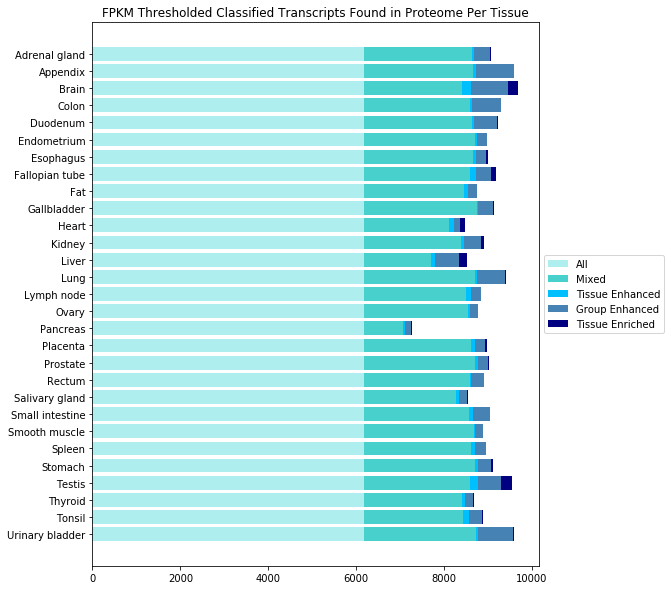

In [88]:
exp_all = sum(~rna_thresh_classified['all'].isnull())

#tissue enriched
tis_enriched=','.join(rna_thresh_classified['t_enriched'][~rna_thresh_classified['t_enriched'].isnull()])
tis_enriched = tis_enriched.split(',')
tis_enriched_counted = Counter(tis_enriched)

#group enriched
grp_enriched=','.join(rna_thresh_classified['g_enriched'][~rna_thresh_classified['g_enriched'].isnull()])
grp_enriched = grp_enriched.split(',')
grp_enriched_counted = Counter(grp_enriched)

#tissue enhanced
tis_enhanced = ','.join(rna_thresh_classified['t_enhanced'][~rna_thresh_classified['t_enhanced'].isnull()])
tis_enhanced = tis_enhanced.split(',')
tis_enhanced_counted = Counter(tis_enhanced)

#Mixed
mixed = ','.join(rna_thresh_classified['mixed'][~rna_thresh_classified['mixed'].isnull()])
mixed = mixed.split(',')
mixed_counted = Counter(mixed)

exp_all_dict={}
for tissue in list(rna_thresh.columns):
    exp_all_dict[tissue] = exp_all
    if tissue not in tis_enriched_counted.keys():
        tis_enriched_counted[tissue]=0
    if tissue not in grp_enriched_counted.keys():
        grp_enriched_counted[tissue]=0
    if tissue not in tis_enhanced_counted.keys():
        tis_enhanced_counted[tissue]=0
    if tissue not in mixed_counted.keys():
        mixed_counted[tissue]=0
exp_all_dict = Counter(exp_all_dict)

classified = pd.DataFrame([exp_all_dict,mixed_counted,tis_enhanced_counted,grp_enriched_counted,tis_enriched_counted]).T
classified.columns=['all','mixed','tis_enhanced','grp_enriched','tis_enriched']
running_sum=classified.cumsum(axis=1)

fig = plt.figure()
ax = fig.add_subplot(111)
fig.set_size_inches((10,10))

ax.barh(classified.index,classified['all'],color='paleturquoise')
ax.barh(classified.index,classified['mixed'],left=running_sum['all'],color='mediumturquoise')
ax.barh(classified.index,classified['tis_enhanced'],left=running_sum['mixed'],color='deepskyblue')
ax.barh(classified.index,classified['grp_enriched'],left=running_sum['tis_enhanced'],color='steelblue')
ax.barh(classified.index,classified['tis_enriched'],left=running_sum['grp_enriched'],color='navy')
ax.invert_yaxis()
ax.set_title("FPKM Thresholded Classified Transcripts Found in Proteome Per Tissue")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(['All','Mixed','Tissue Enhanced','Group Enhanced','Tissue Enriched'],loc='center left', bbox_to_anchor=(1, 0.5))
#fig.savefig('FPKMclassified_transcripts_protein.png',bbox_inches='tight')

In [90]:
rna_fpkm_6725 = rna_fpkm[rna_fpkm['Classification']=='Expressed in all'].index

In [92]:
rna_above_trhesh = rna_fpkm_subset[(rna_fpkm_subset>1).sum(axis=1)==29].index

In [94]:
len(rna_above_trhesh)

6765

In [98]:
set(rna_above_trhesh)-set(rna_fpkm_6725)

{'ENSG00000000971',
 'ENSG00000014641',
 'ENSG00000023330',
 'ENSG00000072042',
 'ENSG00000073060',
 'ENSG00000076351',
 'ENSG00000076555',
 'ENSG00000084693',
 'ENSG00000085662',
 'ENSG00000086619',
 'ENSG00000090382',
 'ENSG00000100577',
 'ENSG00000101608',
 'ENSG00000102755',
 'ENSG00000103994',
 'ENSG00000104812',
 'ENSG00000106351',
 'ENSG00000109846',
 'ENSG00000113790',
 'ENSG00000115414',
 'ENSG00000115486',
 'ENSG00000119711',
 'ENSG00000119927',
 'ENSG00000125730',
 'ENSG00000126709',
 'ENSG00000129757',
 'ENSG00000130203',
 'ENSG00000130208',
 'ENSG00000130707',
 'ENSG00000132541',
 'ENSG00000134531',
 'ENSG00000135046',
 'ENSG00000135919',
 'ENSG00000135929',
 'ENSG00000136811',
 'ENSG00000136867',
 'ENSG00000137714',
 'ENSG00000137801',
 'ENSG00000140263',
 'ENSG00000140416',
 'ENSG00000143153',
 'ENSG00000143499',
 'ENSG00000146674',
 'ENSG00000149476',
 'ENSG00000151726',
 'ENSG00000151729',
 'ENSG00000152620',
 'ENSG00000159713',
 'ENSG00000160213',
 'ENSG00000163110',


In [95]:
'ENSG00000014641' in rna_fpkm_6725

False

In [102]:
rna_fpkm.loc['ENSG00000023330']

Gene name                         ALAS1
Adrenal gland                    560.77
Appendix                          17.62
Brain                             14.04
Colon                             34.73
Duodenum                          30.96
Endometrium                       15.87
Esophagus                         24.32
Fallopian tube                    11.89
Fat                               19.97
Gallbladder                       20.72
Heart                             88.29
Kidney                            27.01
Liver                            343.38
Lung                              44.91
Lymph node                        16.42
Ovary                             11.34
Pancreas                           7.81
Placenta                          22.98
Prostate                          19.26
Rectum                            26.82
Salivary gland                    35.17
Small intestine                   31.93
Smooth muscle                     16.26
Spleen                            11.74
